# Оценивание параметров в Гауссовых смешанных моделях с помощью тензорных разложений

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

In [2]:
#d = 10, k = 6
d = 15 #размерность
k = 7  #число распределений
#k должно быть <= d из-за процедуры отбеливания
n = 500#количество точек
total = k * n  #точек всего
s = 1 #дисперсия
s_out = 2#дисперсия выброса
dist = 20
spher = True
cov_range = 2

### Генерируем данные

In [3]:
#def generate_data():
#    A = -dist+(dist+dist)*np.random.rand(d, k)
#    X = np.zeros((total, d))
#    plt.axis('equal')
#    for i in range(k):
#        mean = np.transpose(A[:, i])
#        if spher:
#            covariance = s * np.identity(d)
#        else:
#            a = -cov_range + (cov_range + cov_range) * np.random.rand(d, d)
#            covariance = np.matmul(np.transpose(a), a)
#        mvn = np.random.multivariate_normal(mean, covariance, n)
        #plt.plot(mvn[:, 0], mvn[:, 1], '.')
        #plt.plot(mean[0], mean[1], 'x')
#        X[i*n:(i+1)*n, :] = mvn
        
        
#    return (X, A)

Данные с выбросом

In [4]:
def generate_data():
    A = -dist+(dist+dist)*np.random.rand(d, k)
    X = np.zeros((total, d))

    plt.axis('equal')

    for i in range(k-1):
        mean = np.transpose(A[:, i])
        if spher:
            covariance = s * np.identity(d)
        else:
            a = -cov_range + (cov_range + cov_range) * np.random.rand(d, d)
            covariance = np.matmul(np.transpose(a), a)
        mvn = np.random.multivariate_normal(mean, covariance, n)
        #plt.plot(mvn[:, 0], mvn[:, 1], '.')
        #plt.plot(mean[0], mean[1], 'x')
        X[i*n:(i+1)*n, :] = mvn
        
        mean = np.transpose(A[:, k-1])
        covariance = s_out * np.identity(d)
        mvn = np.random.multivariate_normal(mean, covariance, n)
        X[(k-1)*n:(k)*n, :] = mvn
        
    return (X, A)

### Вычисляем первый момент (матожидание)

In [5]:
def calculate_first_moment(X):
    mu = np.zeros((d, 1))
    for t in range(total):
        for i in range(d):
            mu[i] += + X[t, i]
    mu /= total
    return mu

### Вычисляем второй момент (ковариационная матрица)

In [6]:
def calculate_second_moment(X):
    Sigma = np.zeros((d, d))
    for t in range(total):
        for i in range(d):
            for j in range(d):
                Sigma[i, j] += np.dot(X[t, i],X[t, j])
    Sigma /= total
    return Sigma

### Извлекаем информацию из второго момента

In [7]:
def extract_information_from_second_moment(Sigma, X):
    U, S, _ = np.linalg.svd(Sigma)
    print("S: ", S)
    s_est = S[-1]
    W, X_whit = perform_whitening(X, U, S)
    return (s_est, W, X_whit)

### Выполняем отбеливание

In [8]:
def perform_whitening(X, U, S):
    W = np.matmul(U[:, 0:k], np.sqrt(np.linalg.pinv(np.diag(S[0:k]))))
    X_whit = np.matmul(X, W)
    return (W, X_whit)

### Выполняем Tensor power method

In [9]:
def perform_tensor_power_method(X_whit, W, s_est, mu):
    TOL = 1e-8
    maxiter = 100
    V_est = np.zeros((k, k))
    lamb = np.zeros((k, 1))

    for i in range(k):
        v_old = np.random.rand(k, 1)
        v_old = np.divide(v_old, np.linalg.norm(v_old))
        for iter in range(maxiter):
            v_new = (np.matmul(np.transpose(X_whit), (np.matmul(X_whit, v_old) * np.matmul(X_whit, v_old)))) / total
            #v_new = v_new - s_est * (W' * mu * dot((W*v_old),(W*v_old)));
            #v_new = v_new - s_est * (2 * W' * W * v_old * ((W'*mu)' * (v_old)));
            v_new -= s_est * (np.matmul(np.matmul(W.T, mu), np.dot(np.matmul(W, v_old).T,np.matmul(W, v_old))))
            v_new -= s_est * (2 * np.matmul(W.T, np.matmul(W, np.matmul(v_old, np.matmul(np.matmul(W.T, mu).T, v_old)))))
            if i > 0:
                for j in range(i):
                    v_new -= np.reshape(V_est[:, j] * np.power(np.matmul(np.transpose(v_old), V_est[:, j]), 2) * lamb[j], (k, 1))
            l = np.linalg.norm(v_new)
            v_new = np.divide(v_new, np.linalg.norm(v_new))
            if np.linalg.norm(v_old - v_new) < TOL:
                V_est[:, i] = np.reshape(v_new, k)
                lamb[i] = l
                break
            v_old = v_new
    
    return (V_est, lamb)

### Применяем обратное преобразование

In [10]:
def perform_backwards_transformation(V_est, lamb):
    return np.matmul(np.matmul(np.linalg.pinv(np.transpose(W)), V_est), np.diag(np.reshape(lamb.T, k)))

### Рисуем результаты

In [11]:
def plot_results(X, A, A_est, s_est):
    plt.axis('equal')
    
    ax = plt.subplot(aspect='equal')
    
    plt.plot(X[:,0], X[:,1], '.', zorder=-3)
    
    for i in range(k):
        mean = A[:, i].T
        mean_est = A_est[:, i].T
        
        plt.plot(mean[0], mean[1], 'x', color='y', zorder=-2)
        plt.plot(mean_est[0], mean_est[1], '+', color='r', zorder=-1)
        
        ell = Ellipse(xy=(mean_est[0], mean_est[1]),
                      width=s_est, height=s_est,
                      angle=0, color='red')
        ell.set_facecolor('none')
        ax.add_artist(ell)

    plt.show()

# Выполнение

S:  [554.03093862 494.12045357 295.74171173 222.51099965 104.66468781
  77.98892327  60.07499796   1.26668485   1.21957903   1.18828741
   1.14870555   1.11813607   1.08976063   1.07127689   1.05576818]


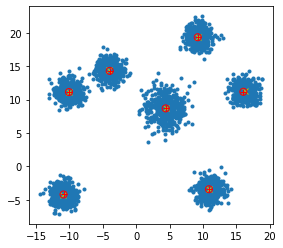

In [12]:
X, A = generate_data()

mu = calculate_first_moment(X)
Sigma = calculate_second_moment(X)

s_est, W, X_whit = extract_information_from_second_moment(Sigma, X)

V_est, lamb = perform_tensor_power_method(X_whit, W, s_est, mu)

A_est = perform_backwards_transformation(V_est, lamb)

plot_results(X, A, A_est, s_est)

У всех, кроме одного дисперсия одинаковая, а у другого дисперсия отличается, можно ли сделать кластеризацию и определить параметр (известен коэффициент)
Определить выброс и указать кластер

Проверить точность алгоритма

In [13]:
print("Средние")
for i in range(k):
    mean = A[:, i].T
    print(mean[:2])
print("Средние, посчитанные алгоритмом")
for i in range(k):
    mean_est = A_est[:, i].T
    print(mean_est[:2])

Средние
[16.31784007 11.30770118]
[-10.11999855  11.1984137 ]
[-10.98478236  -4.25645227]
[-4.0467741  14.46232619]
[10.98845616 -3.45878446]
[ 9.27057022 19.42925926]
[4.50844801 8.73241047]
Средние, посчитанные алгоритмом
[16.07259497 11.17722754]
[4.42864992 8.68513888]
[-10.88264301  -4.21962609]
[-3.95946169 14.30623773]
[10.9142373  -3.43047034]
[ 9.23251926 19.34937652]
[-10.06899745  11.13446984]


In [14]:
print("Оценка на дисперсию")
print(s_est)

Оценка на дисперсию
1.0557681845539797


In [15]:
#e =  np.zeros((k, 1))

#ar = np.dot(np.linalg.pinv(A), calculate_first_moment(X))
#np.dot()

Теперь применим K-means и сравним результаты

Центры кластеров
 [[ 16.22646561  11.28654734]
 [ -4.00887828  14.45638627]
 [-10.94772776  -4.25251606]
 [ 11.00187656  -3.45842992]
 [  9.28719435  19.45648327]
 [  4.45256532   8.73555181]
 [-10.14485696  11.21631224]]


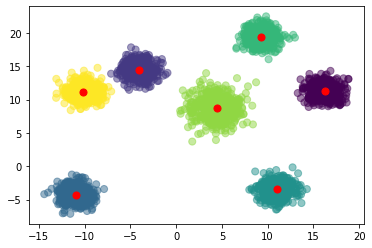

In [16]:
from pandas import DataFrame
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

dim = [0]*k
for i in range(k):
    dim[i] = list()
    
for j in range(k):
    for i in range(len(X)):
        dim[j].append(X[i][j])


Data = {'x': dim[0],
        'y': dim[1]
       }
  
df = DataFrame(Data,columns=['x','y'])
  
kmeans = KMeans(n_clusters=k).fit(df)
centroids = kmeans.cluster_centers_
print("Центры кластеров\n",centroids)

plt.scatter(df['x'], df['y'], c= kmeans.labels_.astype(float), s=50, alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)
plt.show()

А теперь попробуем применить GMM из sklearn

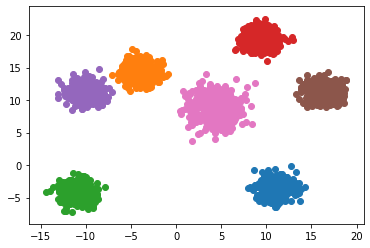

In [17]:

from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=k)
gmm.fit(df)


labels = gmm.predict(df)
frame = df
frame['cluster'] = labels
frame.columns = ['X', 'Y', 'cluster']

for i in range(0,k):
    data = frame[frame["cluster"]==i]
    plt.scatter(data["X"],data["Y"])
plt.show()

In [18]:
gmm.covariances_

array([[[ 9.94011858e-01,  1.46509408e-03],
        [ 1.46509408e-03,  1.03605188e+00]],

       [[ 9.75525956e-01, -4.57515031e-02],
        [-4.57515031e-02,  1.02706662e+00]],

       [[ 9.84588061e-01, -8.27889534e-02],
        [-8.27889534e-02,  1.00541398e+00]],

       [[ 9.33973953e-01, -2.50626095e-02],
        [-2.50626095e-02,  9.99315366e-01]],

       [[ 1.03906787e+00, -4.38946746e-02],
        [-4.38946746e-02,  9.67716644e-01]],

       [[ 1.00705691e+00, -6.37073305e-02],
        [-6.37073305e-02,  9.32172596e-01]],

       [[ 2.10605937e+00, -3.69416761e-02],
        [-3.69416761e-02,  2.34761464e+00]]])

In [19]:
gmm.means_

array([[ 11.00187656,  -3.45842992],
       [ -4.00924063,  14.45644983],
       [-10.94772776,  -4.25251606],
       [  9.28719436,  19.45648328],
       [-10.14479241,  11.21609283],
       [ 16.22646561,  11.28654734],
       [  4.45256068,   8.73555593]])

In [20]:
estimated_means = []
for i in range(k):
    mean_est = A_est[:, i].T
    estimated_means.append(mean_est)

In [21]:
gmm.means_[3]

array([ 9.28719436, 19.45648328])

In [22]:
distances_from_center = [0] * k
for row in frame.iterrows():
    x = row[1][0]
    y = row[1][1]
    c = int(row[1][2])
    dist = (gmm.means_[c][0]-x)**2+(gmm.means_[c][1]-y)**2
    distances_from_center[c] += dist
differences = []
for d in distances_from_center:
    differences.append((d-np.mean(distances_from_center))**2)
ind = differences.index(np.max(differences))
threshold = 2500000
print(np.max(differences))
if np.max(differences) > threshold:
    print("Выброс произошел в кластере номер", ind, "с координатами", gmm.means_[ind])

1120799.9453449382


In [23]:
def multivariateGaussian(X, mu, sigma):
    k = len(mu)
    X = X - mu.T
    p = 1/((2*np.pi)**(k/2)*(np.linalg.det(sigma)**0.5))* np.exp(-0.5* np.sum(X @ np.linalg.pinv(sigma) * X,axis=1))
    return p


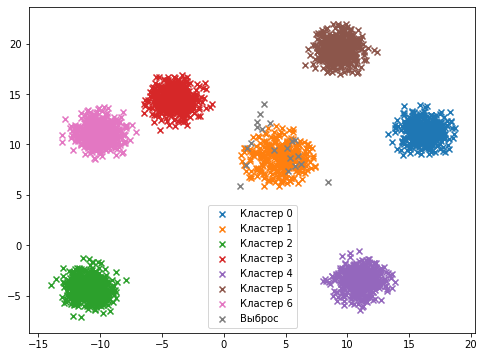

In [24]:
plt.figure(figsize=(8,6))
distances_from_center = [0] * k

#распределим точки по кластерам
for j in range(k):
    p = multivariateGaussian(X,estimated_means[j],Sigma)
    cluster_x = list()
    cluster_y = list()

    list1 = p
    list2 = X
    list1, list2 = zip(*sorted(zip(list1, list2), reverse=True))
    for i in list2[:n]:
        dist = (i[0] - estimated_means[j][0])**2 + (i[1] - estimated_means[j][1])**2
        if (dist < 9*(s_est**2)):
            distances_from_center[j] += dist
            cluster_x.append(i[0])
            cluster_y.append(i[1])
    
    plt.scatter(cluster_x,cluster_y,marker="x",label = "Кластер " +str(j));
    
#найдем точки, которые не должны принадлежать ни одному кластеру   
p_out = 0
for j in range(k):
    p = multivariateGaussian(X,estimated_means[j],Sigma)
    p_out += p
    
list1 = p_out
list2 = X
list1, list2 = zip(*sorted(zip(list1, list2)))
cluster_x = list()
cluster_y = list()
for i in list2[:20]:
    cluster_x.append(i[0])
    cluster_y.append(i[1])
plt.scatter(cluster_x,cluster_y,marker="x",label="Выброс");
plt.legend()
#найдем кластер с отличающейся дисперсией    
differences = []
for d in distances_from_center:
    differences.append((d-np.mean(distances_from_center))**2)
ind = differences.index(np.max(differences))
threshold = 2500000

if np.max(differences) > threshold:
    print("Выброс произошел в кластере номер", ind, "с координатами", estimated_means[ind][0],estimated_means[ind][1])

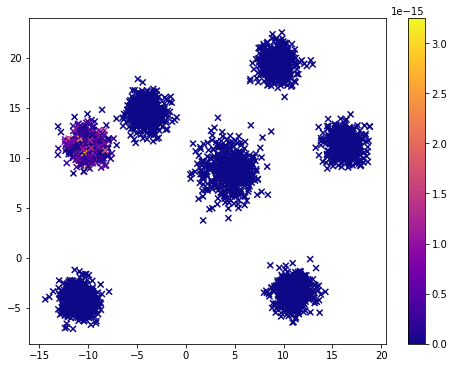

In [25]:
plt.figure(figsize=(8,6))
plt.scatter(X[:,0],X[:,1],marker="x",c=p,cmap='plasma');
plt.colorbar();